In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install xgboost

In [4]:
# 📦 Install required packages
!pip install -q scikit-learn pandas joblib matplotlib

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# === Paths
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
model_xgb_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"
model_rf_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"

# === Load data
df = pd.read_csv(csv_path)

# === Features for prediction
df["age_at_photo"] = df["photo_taken"] - pd.to_datetime(df["dob"]).dt.year
features = ["age_at_photo", "gender", "face_score", "second_face_score"]

# Drop rows with missing data
df_model = df.dropna(subset=features + ["time_to_death"]).copy()
X = df_model[features]
y_true = df_model["time_to_death"]

# === Load models
model_xgb = joblib.load(model_xgb_path)
model_rf = joblib.load(model_rf_path)

# === Predict
y_pred_xgb = model_xgb.predict(X)
y_pred_rf = model_rf.predict(X)

# === Evaluate & Plot function
def evaluate_and_plot(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True Time to Death")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} TTD\nR²={r2:.2f}, MAE={mae:.2f}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()
    return r2, mae

# === Run evaluation
print("📊 XGBoost:")
r2_xgb, mae_xgb = evaluate_and_plot(y_true, y_pred_xgb, "XGBoost")

print("📊 Random Forest:")
r2_rf, mae_rf = evaluate_and_plot(y_true, y_pred_rf, "Random Forest")

ValueError: Feature shape mismatch, expected: 4098, got 4

In [ ]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"  # or reg_rf_ttd.pkl
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler.pkl"

# === Load model and age scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Helper to process images
def process_image(image_path, size=(64, 64)):
    image = Image.open(image_path).convert("L").resize(size)
    return np.array(image).flatten()

# === Load filtered CSV and remove invalid rows
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])

# === Predict
y_true = []
y_pred = []
skipped = 0

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        path = os.path.join(image_dir, row["full_path"])
        img_feat = process_image(path)
        age = row["age_at_photo"]

        # scale age
        scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
        gender = 0  # assume gender is unknown

        # create input vector
        features = np.concatenate([img_feat, [scaled_age, gender]])
        model_input_dim = getattr(model, "n_features_in_", len(features))
        if len(features) < model_input_dim:
            padding = np.zeros(model_input_dim - len(features))
            features = np.concatenate([features, padding])
        elif len(features) > model_input_dim:
            features = features[:model_input_dim]

        pred = model.predict(features.reshape(1, -1))[0]
        y_pred.append(pred)
        y_true.append(row["time_to_death"])
    except:
        skipped += 1

# === Evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"XGBoost TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions. Skipped {skipped} rows.")


✅ Loaded age scaler.


  2%|▏         | 290/12911 [01:55<35:51,  5.87it/s]

✅ Loaded age scaler.
🚀 Predicting with 12911 samples using 32 cores...


100%|██████████| 12911/12911 [01:59<00:00, 108.16it/s]


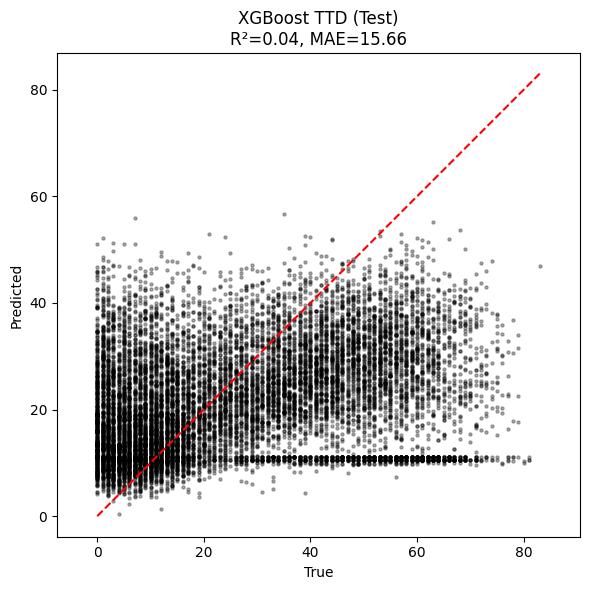

✅ Completed 12911 predictions. Skipped 0 rows.


In [3]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"  # or reg_rf_ttd.pkl
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler.pkl"

# === Load model and age scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Helper to process a single row
def process_and_predict(row):
    try:
        path = os.path.join(image_dir, row["full_path"])
        image = Image.open(path).convert("L").resize((64, 64))
        img_feat = np.array(image).flatten()

        age = row["age_at_photo"]
        scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
        gender = 0  # unknown

        features = np.concatenate([img_feat, [scaled_age, gender]])
        model_input_dim = getattr(model, "n_features_in_", len(features))
        if len(features) < model_input_dim:
            padding = np.zeros(model_input_dim - len(features))
            features = np.concatenate([features, padding])
        elif len(features) > model_input_dim:
            features = features[:model_input_dim]

        prediction = model.predict(features.reshape(1, -1))[0]
        return row["time_to_death"], prediction
    except:
        return None, None

# === Load CSV and drop invalid
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Run in parallel
print(f"🚀 Predicting with {len(df)} samples using 32 cores...")
results = Parallel(n_jobs=32)(
    delayed(process_and_predict)(row) for _, row in tqdm(df.iterrows(), total=len(df))
)

# === Filter valid results
y_true = [r[0] for r in results if r[0] is not None]
y_pred = [r[1] for r in results if r[1] is not None]

# === Evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"XGBoost TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions. Skipped {len(df) - len(y_true)} rows.")


✅ Loaded age scaler.
🚀 Predicting with 12911 samples using 32 cores...


100%|██████████| 12911/12911 [00:59<00:00, 218.24it/s]


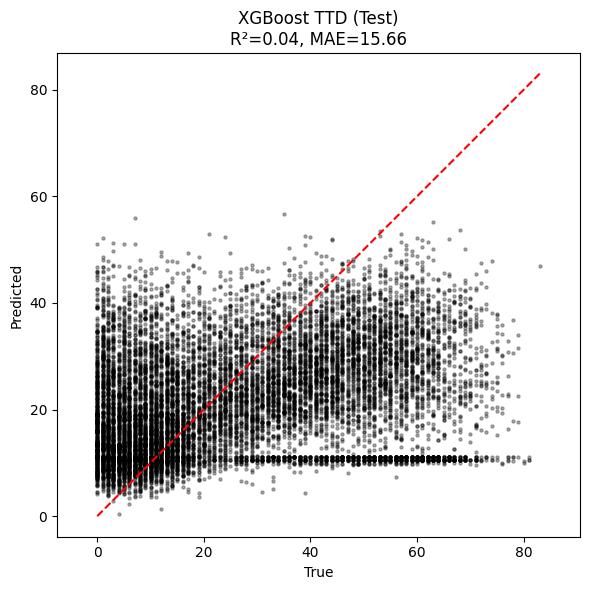

✅ Completed 12911 predictions. Skipped 0 rows.


In [4]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"  # or reg_rf_ttd.pkl
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler.pkl"

# === Load model and age scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Helper to process a single row
def process_and_predict(row):
    try:
        path = os.path.join(image_dir, row["full_path"])
        image = Image.open(path).convert("L").resize((64, 64))
        img_feat = np.array(image).flatten()

        age = row["age_at_photo"]
        scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
        gender = np.nan  # unknown

        features = np.concatenate([img_feat, [scaled_age, gender]])
        model_input_dim = getattr(model, "n_features_in_", len(features))
        if len(features) < model_input_dim:
            padding = np.zeros(model_input_dim - len(features))
            features = np.concatenate([features, padding])
        elif len(features) > model_input_dim:
            features = features[:model_input_dim]

        prediction = model.predict(features.reshape(1, -1))[0]
        return row["time_to_death"], prediction
    except:
        return None, None

# === Load CSV and drop invalid
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Run in parallel
print(f"🚀 Predicting with {len(df)} samples using 32 cores...")
results = Parallel(n_jobs=32)(
    delayed(process_and_predict)(row) for _, row in tqdm(df.iterrows(), total=len(df))
)

# === Filter valid results
y_true = [r[0] for r in results if r[0] is not None]
y_pred = [r[1] for r in results if r[1] is not None]

# === Evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"XGBoost TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions. Skipped {len(df) - len(y_true)} rows.")


⚠️ No scaler found. Using raw age.
🚀 Predicting with 12911 samples using 32 cores...


100%|██████████| 12911/12911 [01:01<00:00, 210.60it/s]


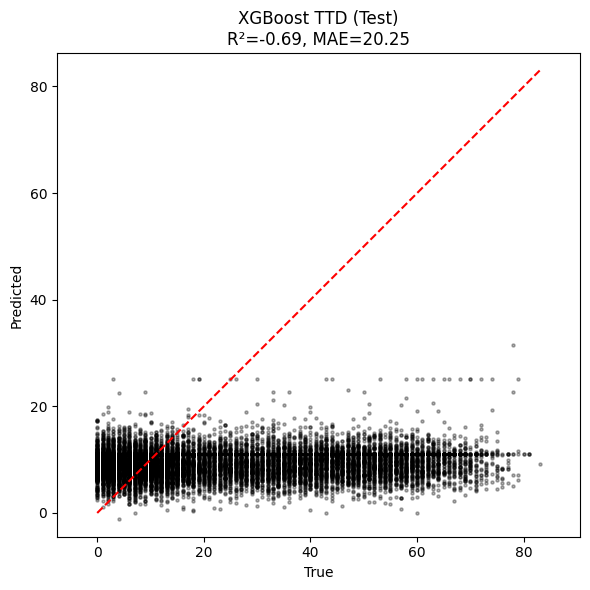

✅ Completed 12911 predictions. Skipped 0 rows.


In [5]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"  # or reg_rf_ttd.pkl
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load model and age scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Helper to process a single row
def process_and_predict(row):
    try:
        path = os.path.join(image_dir, row["full_path"])
        image = Image.open(path).convert("L").resize((64, 64))
        img_feat = np.array(image).flatten()

        age = row["age_at_photo"]
        scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
        gender = np.nan  # unknown

        features = np.concatenate([img_feat, [scaled_age, gender]])
        model_input_dim = getattr(model, "n_features_in_", len(features))
        if len(features) < model_input_dim:
            padding = np.zeros(model_input_dim - len(features))
            features = np.concatenate([features, padding])
        elif len(features) > model_input_dim:
            features = features[:model_input_dim]

        prediction = model.predict(features.reshape(1, -1))[0]
        return row["time_to_death"], prediction
    except:
        return None, None

# === Load CSV and drop invalid
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Run in parallel
print(f"🚀 Predicting with {len(df)} samples using 32 cores...")
results = Parallel(n_jobs=32)(
    delayed(process_and_predict)(row) for _, row in tqdm(df.iterrows(), total=len(df))
)

# === Filter valid results
y_true = [r[0] for r in results if r[0] is not None]
y_pred = [r[1] for r in results if r[1] is not None]

# === Evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"XGBoost TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions. Skipped {len(df) - len(y_true)} rows.")


✅ Loaded age scaler.
🚀 Predicting with 12911 samples using 32 cores...


100%|██████████| 12911/12911 [01:05<00:00, 198.49it/s]


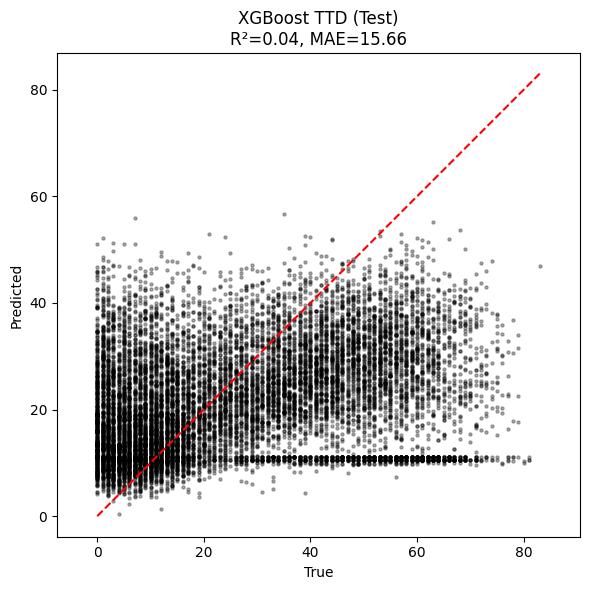

✅ Completed 12911 predictions. Skipped 0 rows.


In [6]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"  # or reg_rf_ttd.pkl
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load model and age scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Helper to process a single row
def process_and_predict(row):
    try:
        path = os.path.join(image_dir, row["full_path"])
        image = Image.open(path).convert("L").resize((64, 64))
        img_feat = np.array(image).flatten()

        age = row["age_at_photo"]
        scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
        gender = np.nan  # unknown

        features = np.concatenate([img_feat, [scaled_age, gender]])
        model_input_dim = getattr(model, "n_features_in_", len(features))
        if len(features) < model_input_dim:
            padding = np.zeros(model_input_dim - len(features))
            features = np.concatenate([features, padding])
        elif len(features) > model_input_dim:
            features = features[:model_input_dim]

        prediction = model.predict(features.reshape(1, -1))[0]
        return row["time_to_death"], prediction
    except:
        return None, None

# === Load CSV and drop invalid
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Run in parallel
print(f"🚀 Predicting with {len(df)} samples using 32 cores...")
results = Parallel(n_jobs=32)(
    delayed(process_and_predict)(row) for _, row in tqdm(df.iterrows(), total=len(df))
)

# === Filter valid results
y_true = [r[0] for r in results if r[0] is not None]
y_pred = [r[1] for r in results if r[1] is not None]

# === Evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"XGBoost TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()
print(f"✅ Completed {len(y_true)} predictions. Skipped {len(df) - len(y_true)} rows.")


In [8]:
for true, pred in zip(y_true[:20], y_pred[:20]):
    print(f"True: {true:.1f} → Predicted: {pred:.1f}")


True: 51.0 → Predicted: 12.0
True: 62.0 → Predicted: 29.7
True: 29.0 → Predicted: 35.8
True: 3.0 → Predicted: 9.7
True: 34.0 → Predicted: 27.3
True: 35.0 → Predicted: 31.0
True: 63.0 → Predicted: 17.4
True: 19.0 → Predicted: 12.2
True: 17.0 → Predicted: 11.5
True: 4.0 → Predicted: 17.3
True: 55.0 → Predicted: 19.9
True: 16.0 → Predicted: 13.0
True: 24.0 → Predicted: 15.0
True: 0.0 → Predicted: 12.1
True: 60.0 → Predicted: 29.7
True: 3.0 → Predicted: 29.9
True: 12.0 → Predicted: 12.6
True: 9.0 → Predicted: 10.7
True: 28.0 → Predicted: 16.1
True: 18.0 → Predicted: 14.7


✅ Loaded age scaler.
🚀 Predicting with 12911 samples using 32 cores...


100%|██████████| 12911/12911 [08:19<00:00, 25.86it/s]


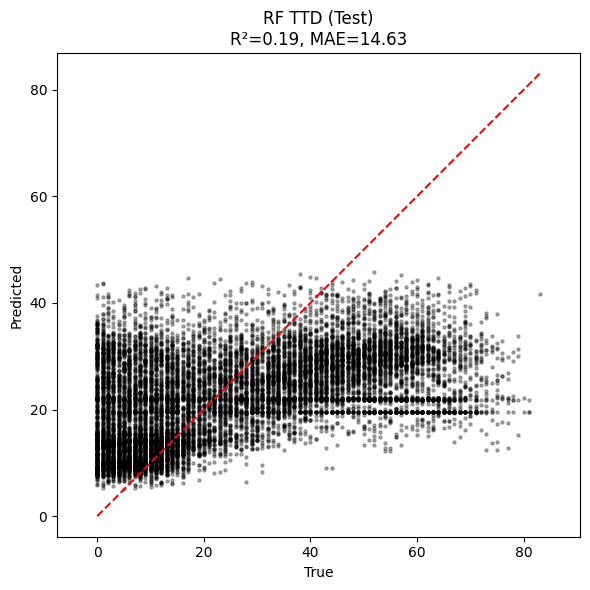

✅ Completed 12911 predictions. Skipped 0 rows.


In [9]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"  # or reg_rf_ttd.pkl
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load model and age scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Helper to process a single row
def process_and_predict(row):
    try:
        path = os.path.join(image_dir, row["full_path"])
        image = Image.open(path).convert("L").resize((64, 64))
        img_feat = np.array(image).flatten()

        age = row["age_at_photo"]
        scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
        gender = np.nan  # unknown

        features = np.concatenate([img_feat, [scaled_age, gender]])
        model_input_dim = getattr(model, "n_features_in_", len(features))
        if len(features) < model_input_dim:
            padding = np.zeros(model_input_dim - len(features))
            features = np.concatenate([features, padding])
        elif len(features) > model_input_dim:
            features = features[:model_input_dim]

        prediction = model.predict(features.reshape(1, -1))[0]
        return row["time_to_death"], prediction
    except:
        return None, None

# === Load CSV and drop invalid
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Run in parallel
print(f"🚀 Predicting with {len(df)} samples using 32 cores...")
results = Parallel(n_jobs=32)(
    delayed(process_and_predict)(row) for _, row in tqdm(df.iterrows(), total=len(df))
)

# === Filter valid results
y_true = [r[0] for r in results if r[0] is not None]
y_pred = [r[1] for r in results if r[1] is not None]

# === Evaluation
y_true = np.array(y_true)
y_pred = np.array(y_pred)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"RF TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()
print(f"✅ Completed {len(y_true)} predictions. Skipped {len(df) - len(y_true)} rows.")


✅ Loaded age scaler.
📦 Loading cached image features...
📐 Padded to match model's input: 4436 features.
📊 Running predictions...


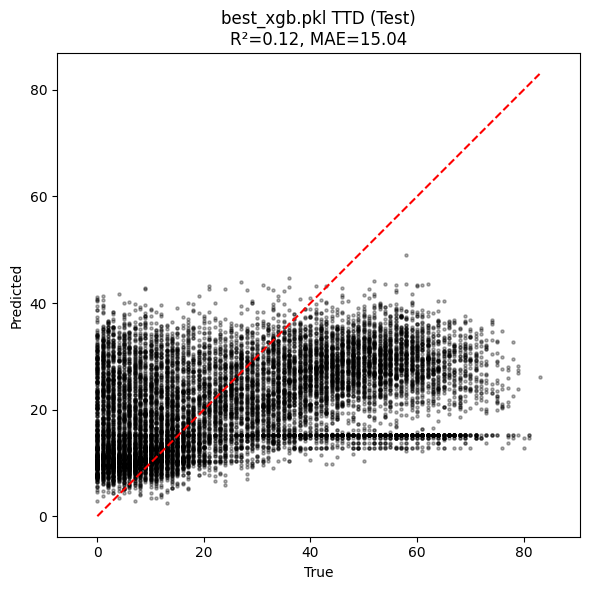

✅ Completed 12911 predictions.


In [12]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load model and scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Load CSV
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Load or extract image features
if os.path.exists(cache_path):
    print("📦 Loading cached image features...")
    image_features = np.load(cache_path)
else:
    print("🔄 Extracting image features...")

    def extract_image(path):
        try:
            img = Image.open(os.path.join(image_dir, path)).convert("L").resize((64, 64))
            return np.array(img).flatten()
        except:
            return None

    image_features = Parallel(n_jobs=32)(
        delayed(extract_image)(fp) for fp in tqdm(df["full_path"])
    )
    valid_idx = [i for i, feat in enumerate(image_features) if feat is not None]
    df = df.iloc[valid_idx].reset_index(drop=True)
    image_features = np.array([image_features[i] for i in valid_idx])
    np.save(cache_path, image_features)
    print("✅ Cached image features saved.")

# === Prepare metadata
ages = df["age_at_photo"].values.reshape(-1, 1)
scaled_ages = age_scaler.transform(ages).flatten() if age_scaler else ages.flatten()
genders = np.full_like(scaled_ages, fill_value=np.nan)

# === Assemble full feature matrix
base_features = np.concatenate([image_features, scaled_ages[:, None], genders[:, None]], axis=1)

# === Match model expected input size
expected_features = getattr(model, "n_features_in_", base_features.shape[1])
if base_features.shape[1] < expected_features:
    X = np.hstack([base_features, np.zeros((base_features.shape[0], expected_features - base_features.shape[1]))])
    print(f"📐 Padded to match model's input: {expected_features} features.")
elif base_features.shape[1] > expected_features:
    X = base_features[:, :expected_features]
    print(f"✂️ Truncated features to: {expected_features}.")
else:
    X = base_features

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"best_xgb.pkl TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions.")


✅ Loaded age scaler.
📦 Loading cached image features...
📊 Running predictions...


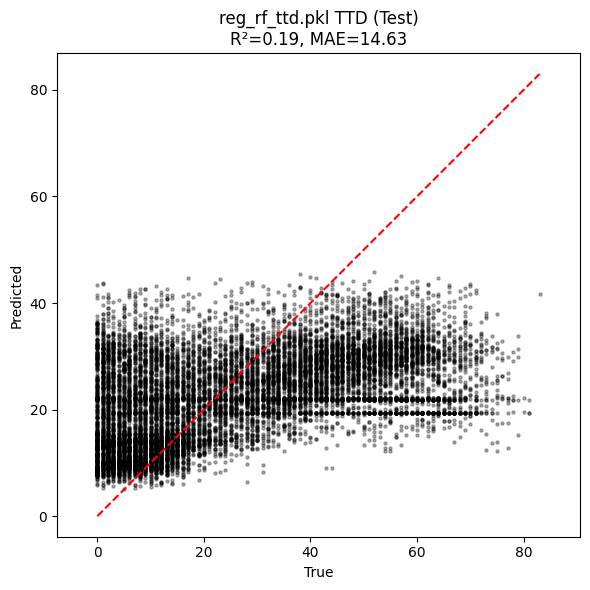

✅ Completed 12911 predictions.


In [16]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load model and scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Load CSV
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Load or extract image features
if os.path.exists(cache_path):
    print("📦 Loading cached image features...")
    image_features = np.load(cache_path)
else:
    print("🔄 Extracting image features...")

    def extract_image(path):
        try:
            img = Image.open(os.path.join(image_dir, path)).convert("L").resize((64, 64))
            return np.array(img).flatten()
        except:
            return None

    image_features = Parallel(n_jobs=32)(
        delayed(extract_image)(fp) for fp in tqdm(df["full_path"])
    )
    valid_idx = [i for i, feat in enumerate(image_features) if feat is not None]
    df = df.iloc[valid_idx].reset_index(drop=True)
    image_features = np.array([image_features[i] for i in valid_idx])
    np.save(cache_path, image_features)
    print("✅ Cached image features saved.")

# === Prepare metadata
ages = df["age_at_photo"].values.reshape(-1, 1)
scaled_ages = age_scaler.transform(ages).flatten() if age_scaler else ages.flatten()
genders = np.full_like(scaled_ages, fill_value=np.nan)

# === Assemble full feature matrix
base_features = np.concatenate([image_features, scaled_ages[:, None], genders[:, None]], axis=1)

# === Match model expected input size
expected_features = getattr(model, "n_features_in_", base_features.shape[1])
if base_features.shape[1] < expected_features:
    X = np.hstack([base_features, np.zeros((base_features.shape[0], expected_features - base_features.shape[1]))])
    print(f"📐 Padded to match model's input: {expected_features} features.")
elif base_features.shape[1] > expected_features:
    X = base_features[:, :expected_features]
    print(f"✂️ Truncated features to: {expected_features}.")
else:
    X = base_features

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"reg_rf_ttd.pkl TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions.")


✅ Loaded age scaler.
📦 Loading cached image features...
📊 Running predictions...


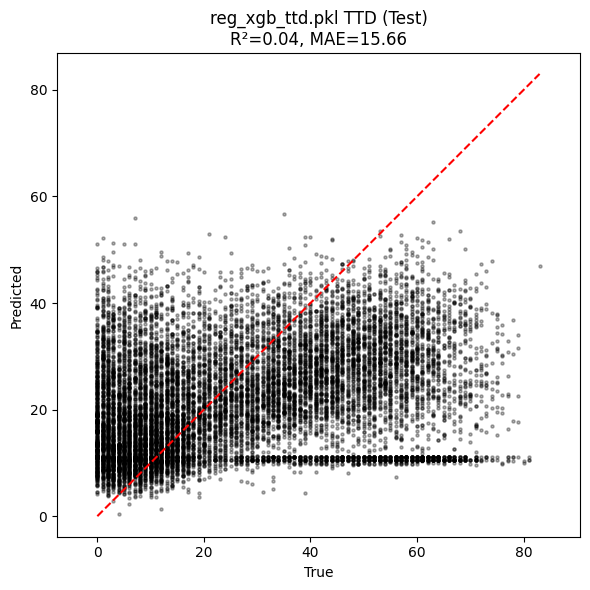

✅ Completed 12911 predictions.


In [17]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from joblib import Parallel, delayed

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load model and scaler ===
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Load CSV
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Load or extract image features
if os.path.exists(cache_path):
    print("📦 Loading cached image features...")
    image_features = np.load(cache_path)
else:
    print("🔄 Extracting image features...")

    def extract_image(path):
        try:
            img = Image.open(os.path.join(image_dir, path)).convert("L").resize((64, 64))
            return np.array(img).flatten()
        except:
            return None

    image_features = Parallel(n_jobs=32)(
        delayed(extract_image)(fp) for fp in tqdm(df["full_path"])
    )
    valid_idx = [i for i, feat in enumerate(image_features) if feat is not None]
    df = df.iloc[valid_idx].reset_index(drop=True)
    image_features = np.array([image_features[i] for i in valid_idx])
    np.save(cache_path, image_features)
    print("✅ Cached image features saved.")

# === Prepare metadata
ages = df["age_at_photo"].values.reshape(-1, 1)
scaled_ages = age_scaler.transform(ages).flatten() if age_scaler else ages.flatten()
genders = np.full_like(scaled_ages, fill_value=np.nan)

# === Assemble full feature matrix
base_features = np.concatenate([image_features, scaled_ages[:, None], genders[:, None]], axis=1)

# === Match model expected input size
expected_features = getattr(model, "n_features_in_", base_features.shape[1])
if base_features.shape[1] < expected_features:
    X = np.hstack([base_features, np.zeros((base_features.shape[0], expected_features - base_features.shape[1]))])
    print(f"📐 Padded to match model's input: {expected_features} features.")
elif base_features.shape[1] > expected_features:
    X = base_features[:, :expected_features]
    print(f"✂️ Truncated features to: {expected_features}.")
else:
    X = base_features

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"reg_xgb_ttd.pkl TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions.")


✅ Filtered to 12025 samples with TTD ≤ 60 years
✅ Loaded age scaler.
🔄 Extracting image features...


100%|██████████| 12025/12025 [00:36<00:00, 329.28it/s]


✅ Image features saved for future runs.
📊 Running predictions...


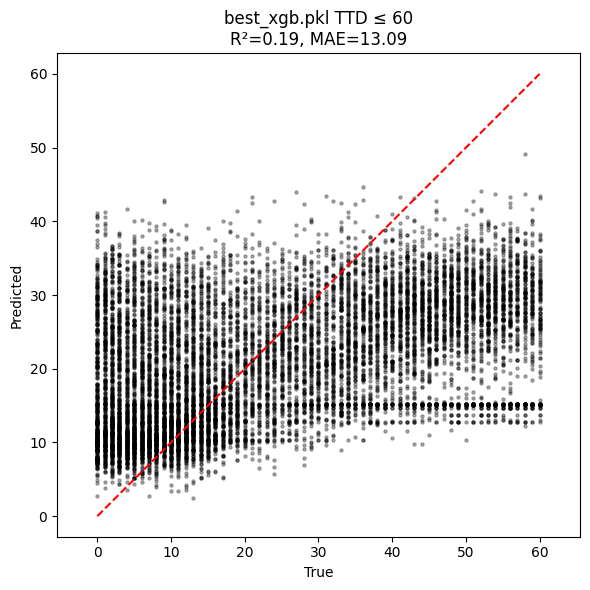

✅ Completed 12025 predictions with TTD ≤ 60


In [18]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached_ttd60.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load CSV and filter
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 60].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 60 years")

# === Load scaler and model
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Precompute or load image features
if os.path.exists(cache_path):
    X = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image_path = os.path.join(image_dir, row["full_path"])
            image = Image.open(image_path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()

            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan  # if unknown or unused

            f = np.concatenate([img_feat, [scaled_age, gender]])
            model_input_dim = getattr(model, "n_features_in_", len(f))
            if len(f) < model_input_dim:
                padding = np.zeros(model_input_dim - len(f))
                f = np.concatenate([f, padding])
            elif len(f) > model_input_dim:
                f = f[:model_input_dim]

            features.append(f)
        except:
            features.append(None)

    X = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X)
    print("✅ Image features saved for future runs.")

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"best_xgb.pkl TTD ≤ 60\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions with TTD ≤ 60")


In [20]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached_ttd60.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load CSV and filter
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 60].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 60 years")

# === Load scaler and model
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Precompute or load image features
if os.path.exists(cache_path):
    X = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image_path = os.path.join(image_dir, row["full_path"])
            image = Image.open(image_path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()

            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan  # if unknown or unused

            f = np.concatenate([img_feat, [scaled_age, gender]])
            model_input_dim = getattr(model, "n_features_in_", len(f))
            if len(f) < model_input_dim:
                padding = np.zeros(model_input_dim - len(f))
                f = np.concatenate([f, padding])
            elif len(f) > model_input_dim:
                f = f[:model_input_dim]

            features.append(f)
        except:
            features.append(None)

    X = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X)
    print("✅ Image features saved for future runs.")

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"reg_xgb_ttd.pkl TTD ≤ 60\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions with TTD ≤ 60")


✅ Filtered to 12025 samples with TTD ≤ 60 years
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached_ttd60.npy
📊 Running predictions...


ValueError: Feature shape mismatch, expected: 4098, got 4436

✅ Filtered to 9931 samples with TTD ≤ 50 years
✅ Loaded age scaler.
🔄 Extracting image features...


100%|██████████| 9931/9931 [00:30<00:00, 327.98it/s]


✅ Image features saved for future runs.
📊 Running predictions...


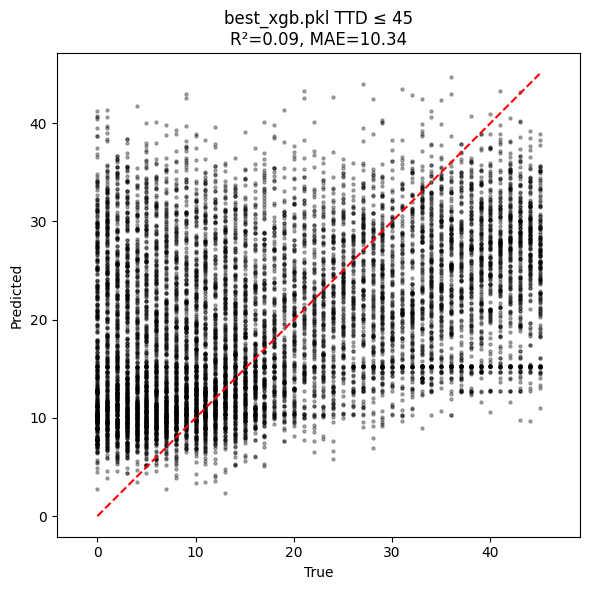

✅ Completed 9931 predictions with TTD ≤ 45


In [23]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached_ttd45.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load CSV and filter
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 45].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 50 years")

# === Load scaler and model
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Precompute or load image features
if os.path.exists(cache_path):
    X = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image_path = os.path.join(image_dir, row["full_path"])
            image = Image.open(image_path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()

            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan  # if unknown or unused

            f = np.concatenate([img_feat, [scaled_age, gender]])
            model_input_dim = getattr(model, "n_features_in_", len(f))
            if len(f) < model_input_dim:
                padding = np.zeros(model_input_dim - len(f))
                f = np.concatenate([f, padding])
            elif len(f) > model_input_dim:
                f = f[:model_input_dim]

            features.append(f)
        except:
            features.append(None)

    X = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X)
    print("✅ Image features saved for future runs.")

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"best_xgb.pkl TTD ≤ 45\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions with TTD ≤ 45")


✅ Filtered to 7978 samples with 5 ≤ TTD ≤ 45 years
✅ Loaded age scaler.
🔄 Extracting image features...


100%|██████████| 7978/7978 [00:24<00:00, 328.86it/s]


✅ Image features saved for future runs.
📊 Running predictions...


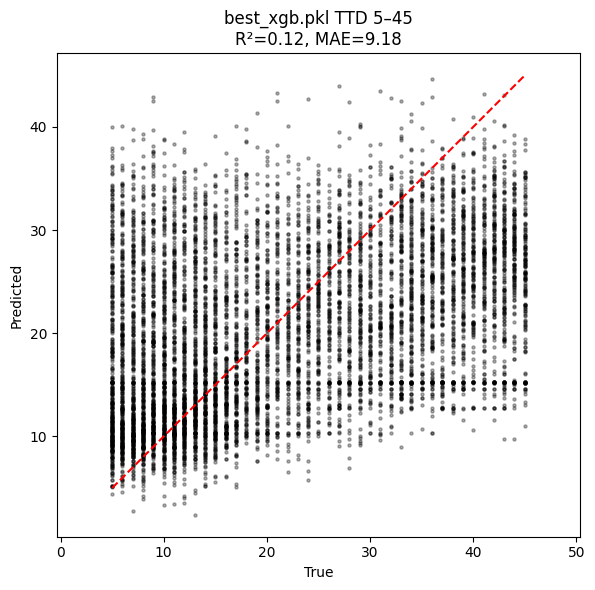

✅ Completed 7978 predictions for TTD between 5 and 45 years.


In [21]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached_ttd_5to45.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load CSV and filter
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[(df["time_to_death"] >= 5) & (df["time_to_death"] <= 45)].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with 5 ≤ TTD ≤ 45 years")

# === Load scaler and model
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Precompute or load image features
if os.path.exists(cache_path):
    X = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image_path = os.path.join(image_dir, row["full_path"])
            image = Image.open(image_path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()

            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan  # if unknown or unused

            f = np.concatenate([img_feat, [scaled_age, gender]])
            model_input_dim = getattr(model, "n_features_in_", len(f))
            if len(f) < model_input_dim:
                padding = np.zeros(model_input_dim - len(f))
                f = np.concatenate([f, padding])
            elif len(f) > model_input_dim:
                f = f[:model_input_dim]

            features.append(f)
        except:
            features.append(None)

    X = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X)
    print("✅ Image features saved for future runs.")

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"best_xgb.pkl TTD 5–45\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions for TTD between 5 and 45 years.")

✅ Filtered to 10663 samples with TTD ≤ 50 years
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached_ttd50.npy
📊 Running predictions...


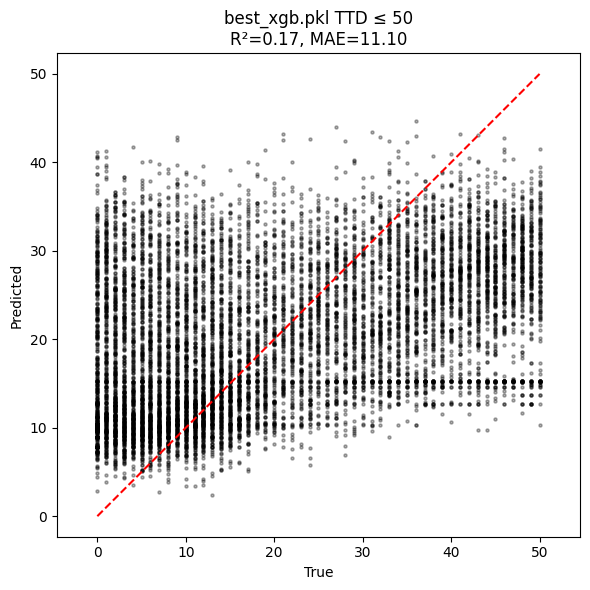

✅ Completed 10663 predictions with TTD ≤ 50


In [24]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
cache_path = "/content/image_features_cached_ttd50.npy"
model_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"

# === Load CSV and filter
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 50].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 50 years")

# === Load scaler and model
model = joblib.load(model_path)
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Precompute or load image features
if os.path.exists(cache_path):
    X = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image_path = os.path.join(image_dir, row["full_path"])
            image = Image.open(image_path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()

            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan  # if unknown or unused

            f = np.concatenate([img_feat, [scaled_age, gender]])
            model_input_dim = getattr(model, "n_features_in_", len(f))
            if len(f) < model_input_dim:
                padding = np.zeros(model_input_dim - len(f))
                f = np.concatenate([f, padding])
            elif len(f) > model_input_dim:
                f = f[:model_input_dim]

            features.append(f)
        except:
            features.append(None)

    X = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X)
    print("✅ Image features saved for future runs.")

# === Predict
print("📊 Running predictions...")
y_true = df["time_to_death"].values
y_pred = model.predict(X)

# === Evaluate
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

# === Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title(f"best_xgb.pkl TTD ≤ 50\nR²={r2:.2f}, MAE={mae:.2f}")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Completed {len(y_true)} predictions with TTD ≤ 50")


✅ Filtered to 10663 samples with TTD ≤ 50 years
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached_ttd50.npy

🔍 Evaluating best_xgb.pkl...

🔍 Evaluating reg_xgb_ttd.pkl...

🔍 Evaluating reg_rf_ttd.pkl...


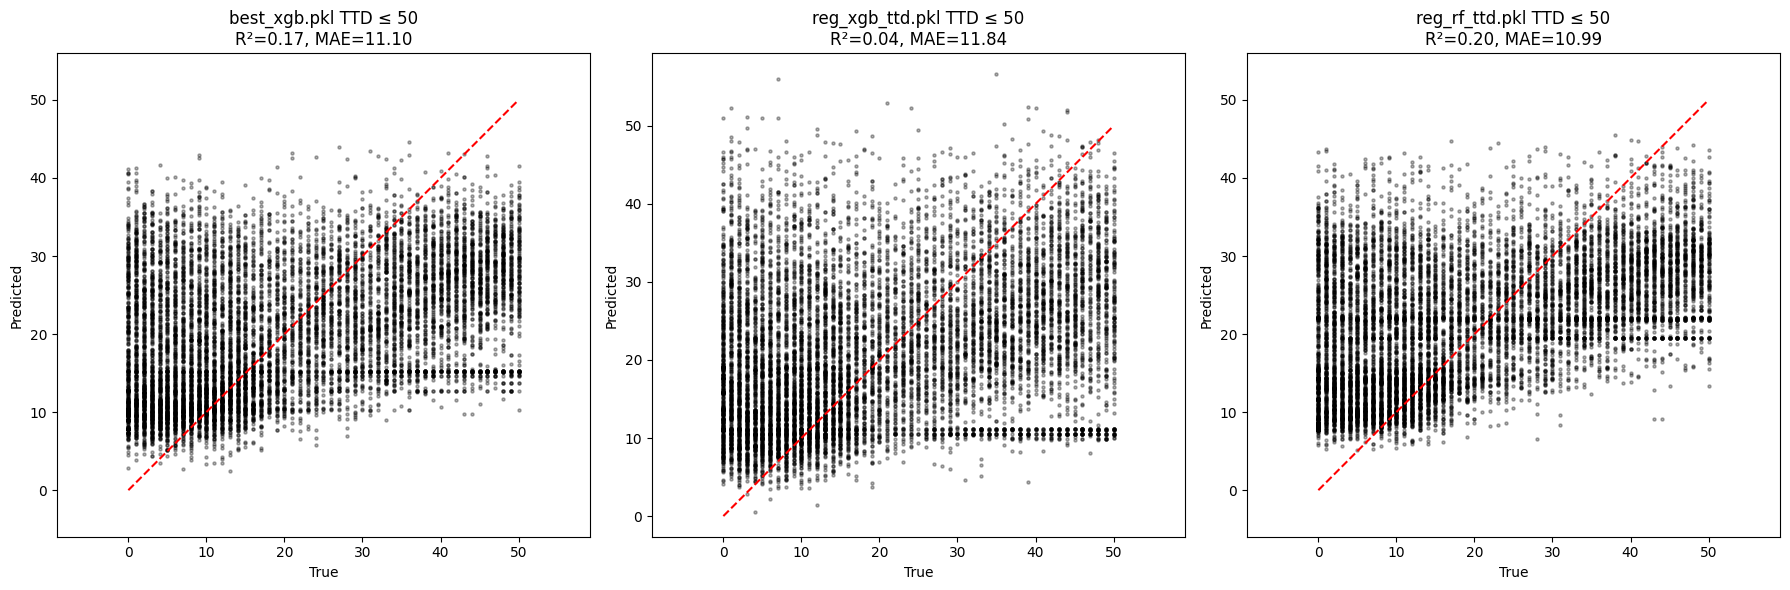

In [25]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached_ttd50.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
}

# === Load CSV and filter
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 50].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 50 years")

# === Load age scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Precompute or load image features
if os.path.exists(cache_path):
    X = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            image_path = os.path.join(image_dir, row["full_path"])
            image = Image.open(image_path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()

            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan  # not used

            f = np.concatenate([img_feat, [scaled_age, gender]])
            features.append(f)
        except:
            features.append(None)

    X = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X)
    print("✅ Image features saved for future runs.")

# === Run predictions and plot for each model
y_true = df["time_to_death"].values
plt.figure(figsize=(18, 6))

for i, (label, model_path) in enumerate(model_paths.items()):
    model = joblib.load(model_path)
    print(f"\n🔍 Evaluating {label}...")

    # Adjust features to match model input
    features_adj = []
    for f in X:
        model_input_dim = getattr(model, "n_features_in_", len(f))
        if len(f) < model_input_dim:
            padding = np.zeros(model_input_dim - len(f))
            f_adj = np.concatenate([f, padding])
        elif len(f) > model_input_dim:
            f_adj = f[:model_input_dim]
        else:
            f_adj = f
        features_adj.append(f_adj)

    X_adj = np.array(features_adj)

    y_pred = model.predict(X_adj)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # === Plot
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{label} TTD ≤ 50\nR²={r2:.2f}, MAE={mae:.2f}")
    plt.axis("equal")

plt.tight_layout()
plt.show()


✅ Loaded full dataset with 12911 entries
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached.npy
📊 Evaluating best_xgb.pkl on TTD: All with 12911 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: All with 12911 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: All with 12911 samples
📊 Evaluating best_xgb.pkl on TTD: ≤ 60 with 12025 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: ≤ 60 with 12025 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: ≤ 60 with 12025 samples
📊 Evaluating best_xgb.pkl on TTD: ≤ 45 with 9931 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: ≤ 45 with 9931 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: ≤ 45 with 9931 samples
📊 Evaluating best_xgb.pkl on TTD: 5–50 with 8710 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: 5–50 with 8710 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: 5–50 with 8710 samples


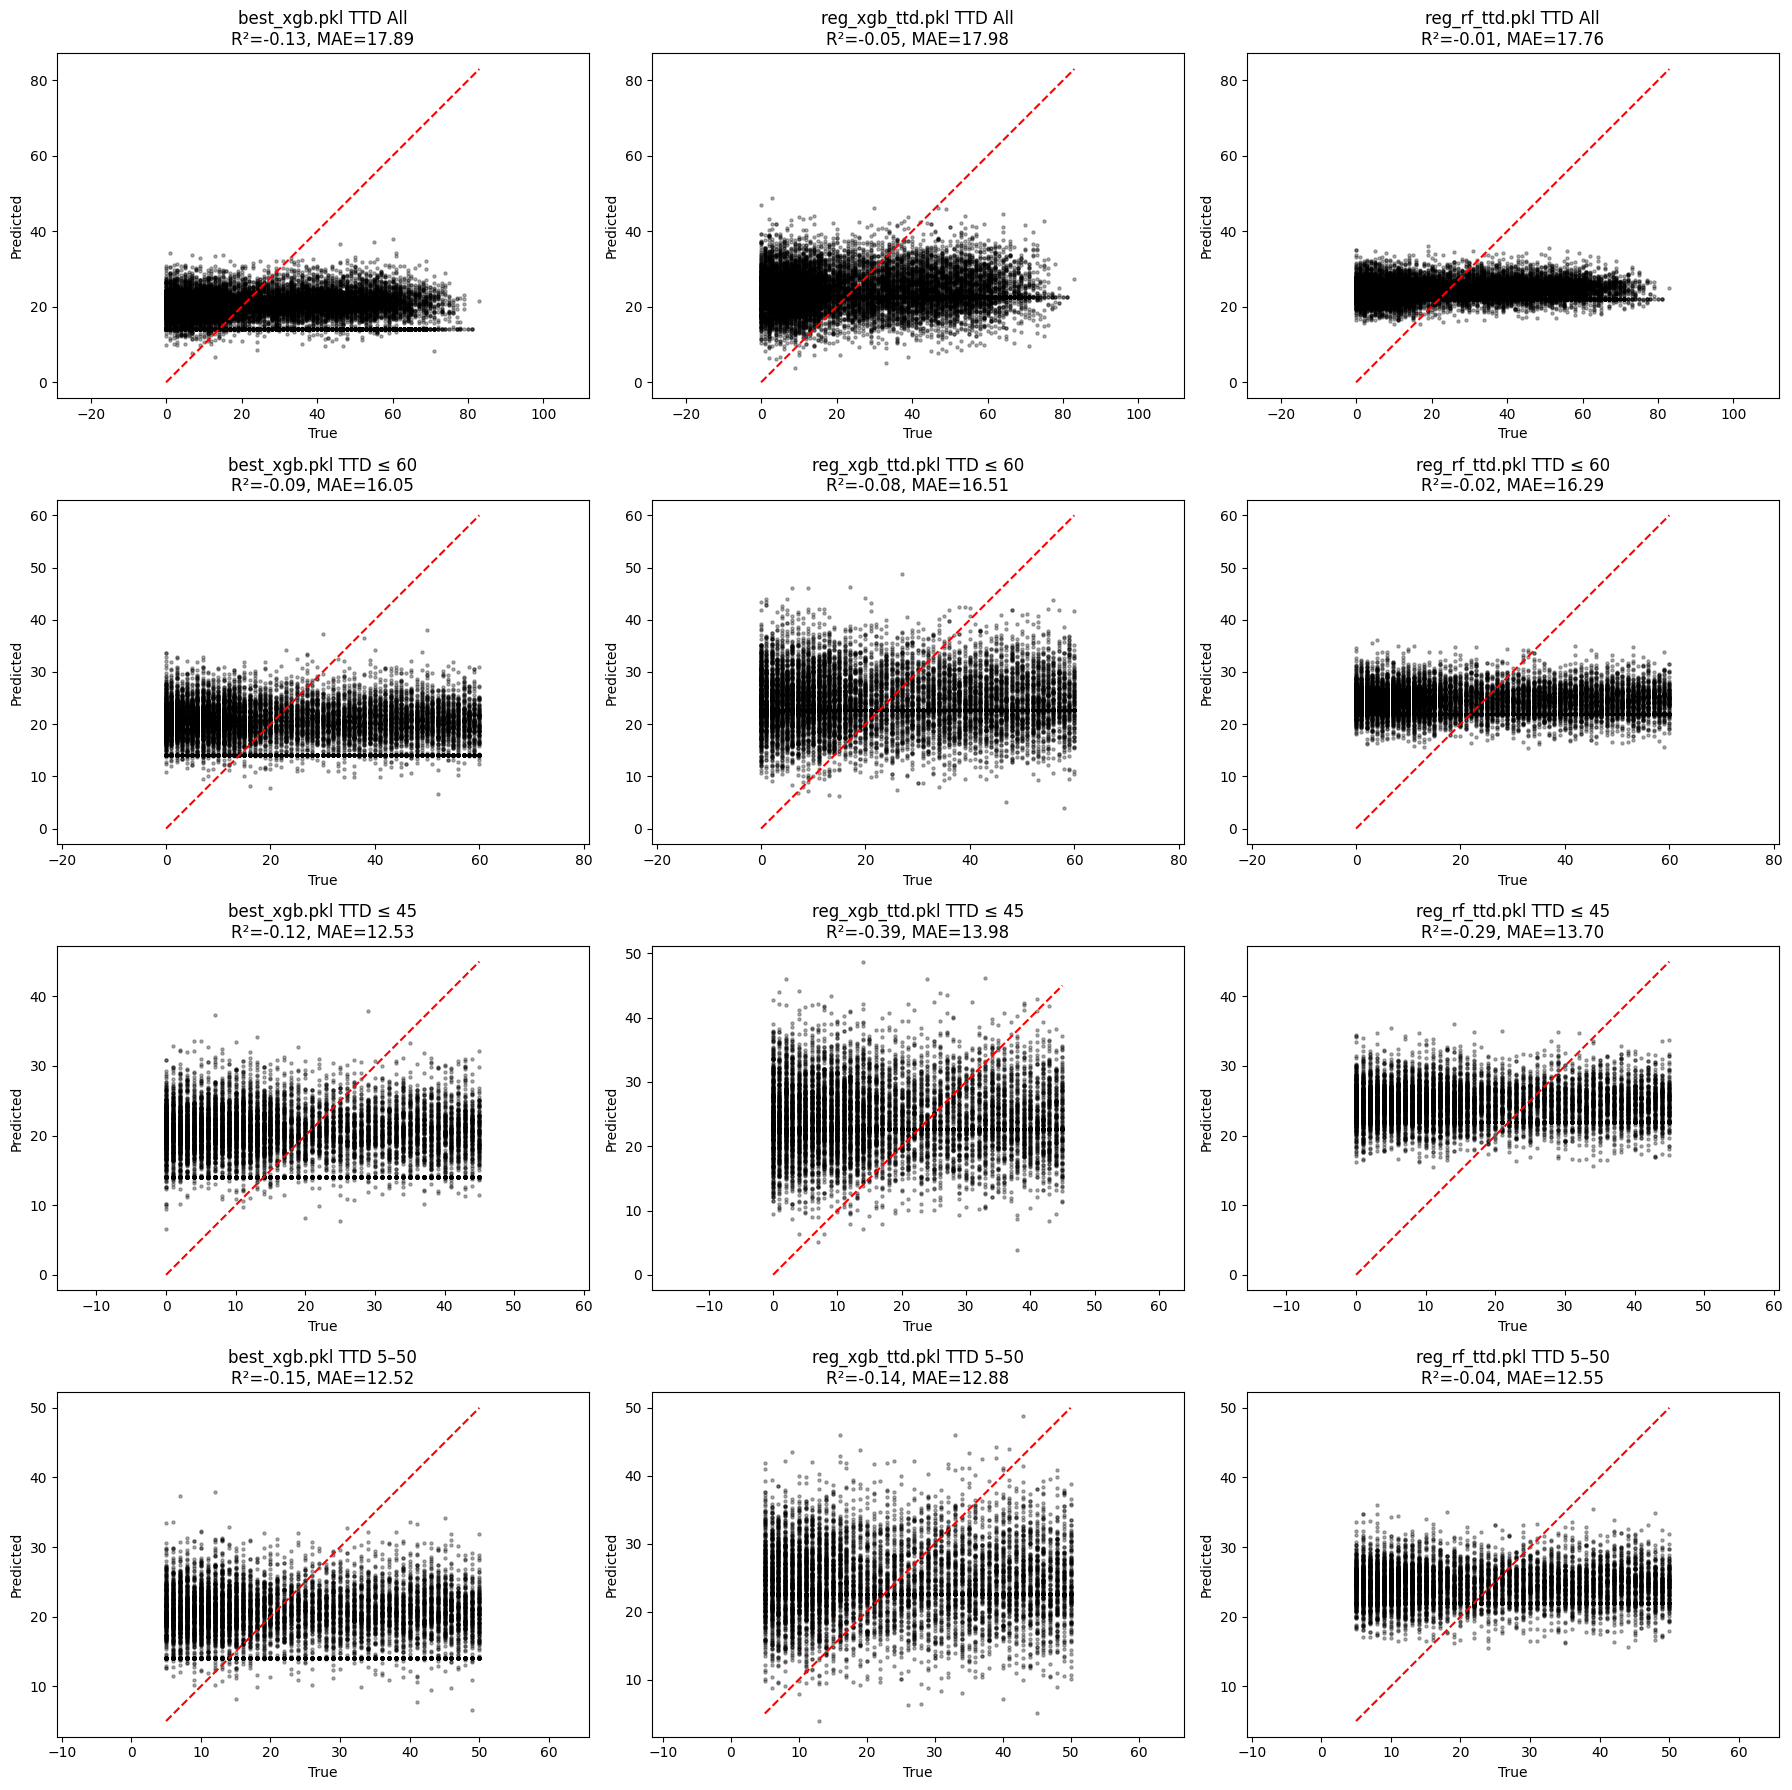

In [26]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
}

ttd_filters = {
    "All": lambda df: df,
    "≤ 60": lambda df: df[df["time_to_death"] <= 60],
    "≤ 45": lambda df: df[df["time_to_death"] <= 45],
    "5–50": lambda df: df[(df["time_to_death"] >= 5) & (df["time_to_death"] <= 50)]
}

# === Load CSV
df_full = pd.read_csv(csv_path)
df_full = df_full.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)
print(f"✅ Loaded full dataset with {len(df_full)} entries")

# === Load age scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Extract and cache image features
if os.path.exists(cache_path):
    X_all = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df_full.iterrows(), total=len(df_full)):
        try:
            path = os.path.join(image_dir, row["full_path"])
            image = Image.open(path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()
            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan
            f = np.concatenate([img_feat, [scaled_age, gender]])
            features.append(f)
        except:
            features.append(None)

    X_all = np.array([f for f in features if f is not None])
    df_full = df_full.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X_all)
    print("✅ Saved image features to cache.")

# === Plotting setup
plt.figure(figsize=(18, 18))
row_idx = 1

for ttd_label, ttd_filter in ttd_filters.items():
    df_filtered = ttd_filter(df_full).reset_index(drop=True)
    y_true_all = df_filtered["time_to_death"].values

    # Match features
    filtered_indices = df_filtered.index.values
    X = X_all[filtered_indices]

    col_idx = 1
    for model_label, model_path in model_paths.items():
        model = joblib.load(model_path)
        print(f"📊 Evaluating {model_label} on TTD: {ttd_label} with {len(df_filtered)} samples")

        features_adj = []
        for f in X:
            model_input_dim = getattr(model, "n_features_in_", len(f))
            if len(f) < model_input_dim:
                f = np.concatenate([f, np.zeros(model_input_dim - len(f))])
            elif len(f) > model_input_dim:
                f = f[:model_input_dim]
            features_adj.append(f)

        X_adj = np.array(features_adj)
        y_pred = model.predict(X_adj)
        r2 = r2_score(y_true_all, y_pred)
        mae = mean_absolute_error(y_true_all, y_pred)

        # Subplot
        plt.subplot(len(ttd_filters), len(model_paths), (row_idx - 1) * 3 + col_idx)
        plt.scatter(y_true_all, y_pred, s=5, color='black', alpha=0.3)
        plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'r--')
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(f"{model_label} TTD {ttd_label}\nR²={r2:.2f}, MAE={mae:.2f}")
        plt.axis("equal")

        col_idx += 1
    row_idx += 1

plt.tight_layout()
plt.show()

✅ Loaded full dataset with 12911 entries
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached.npy
📊 Evaluating best_xgb.pkl on TTD: All with 12911 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: All with 12911 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: All with 12911 samples
📊 Evaluating best_xgb.pkl on TTD: ≤ 60 with 12025 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: ≤ 60 with 12025 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: ≤ 60 with 12025 samples
📊 Evaluating best_xgb.pkl on TTD: ≤ 50 with 10663 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: ≤ 50 with 10663 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: ≤ 50 with 10663 samples
📊 Evaluating best_xgb.pkl on TTD: ≤ 45 with 9931 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: ≤ 45 with 9931 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: ≤ 45 with 9931 samples
📊 Evaluating best_xgb.pkl on TTD: 5–50 with 8710 samples
📊 Evaluating reg_xgb_ttd.pkl on TTD: 5–50 with 8710 samples
📊 Evaluating reg_rf_ttd.pkl on TTD: 5–50

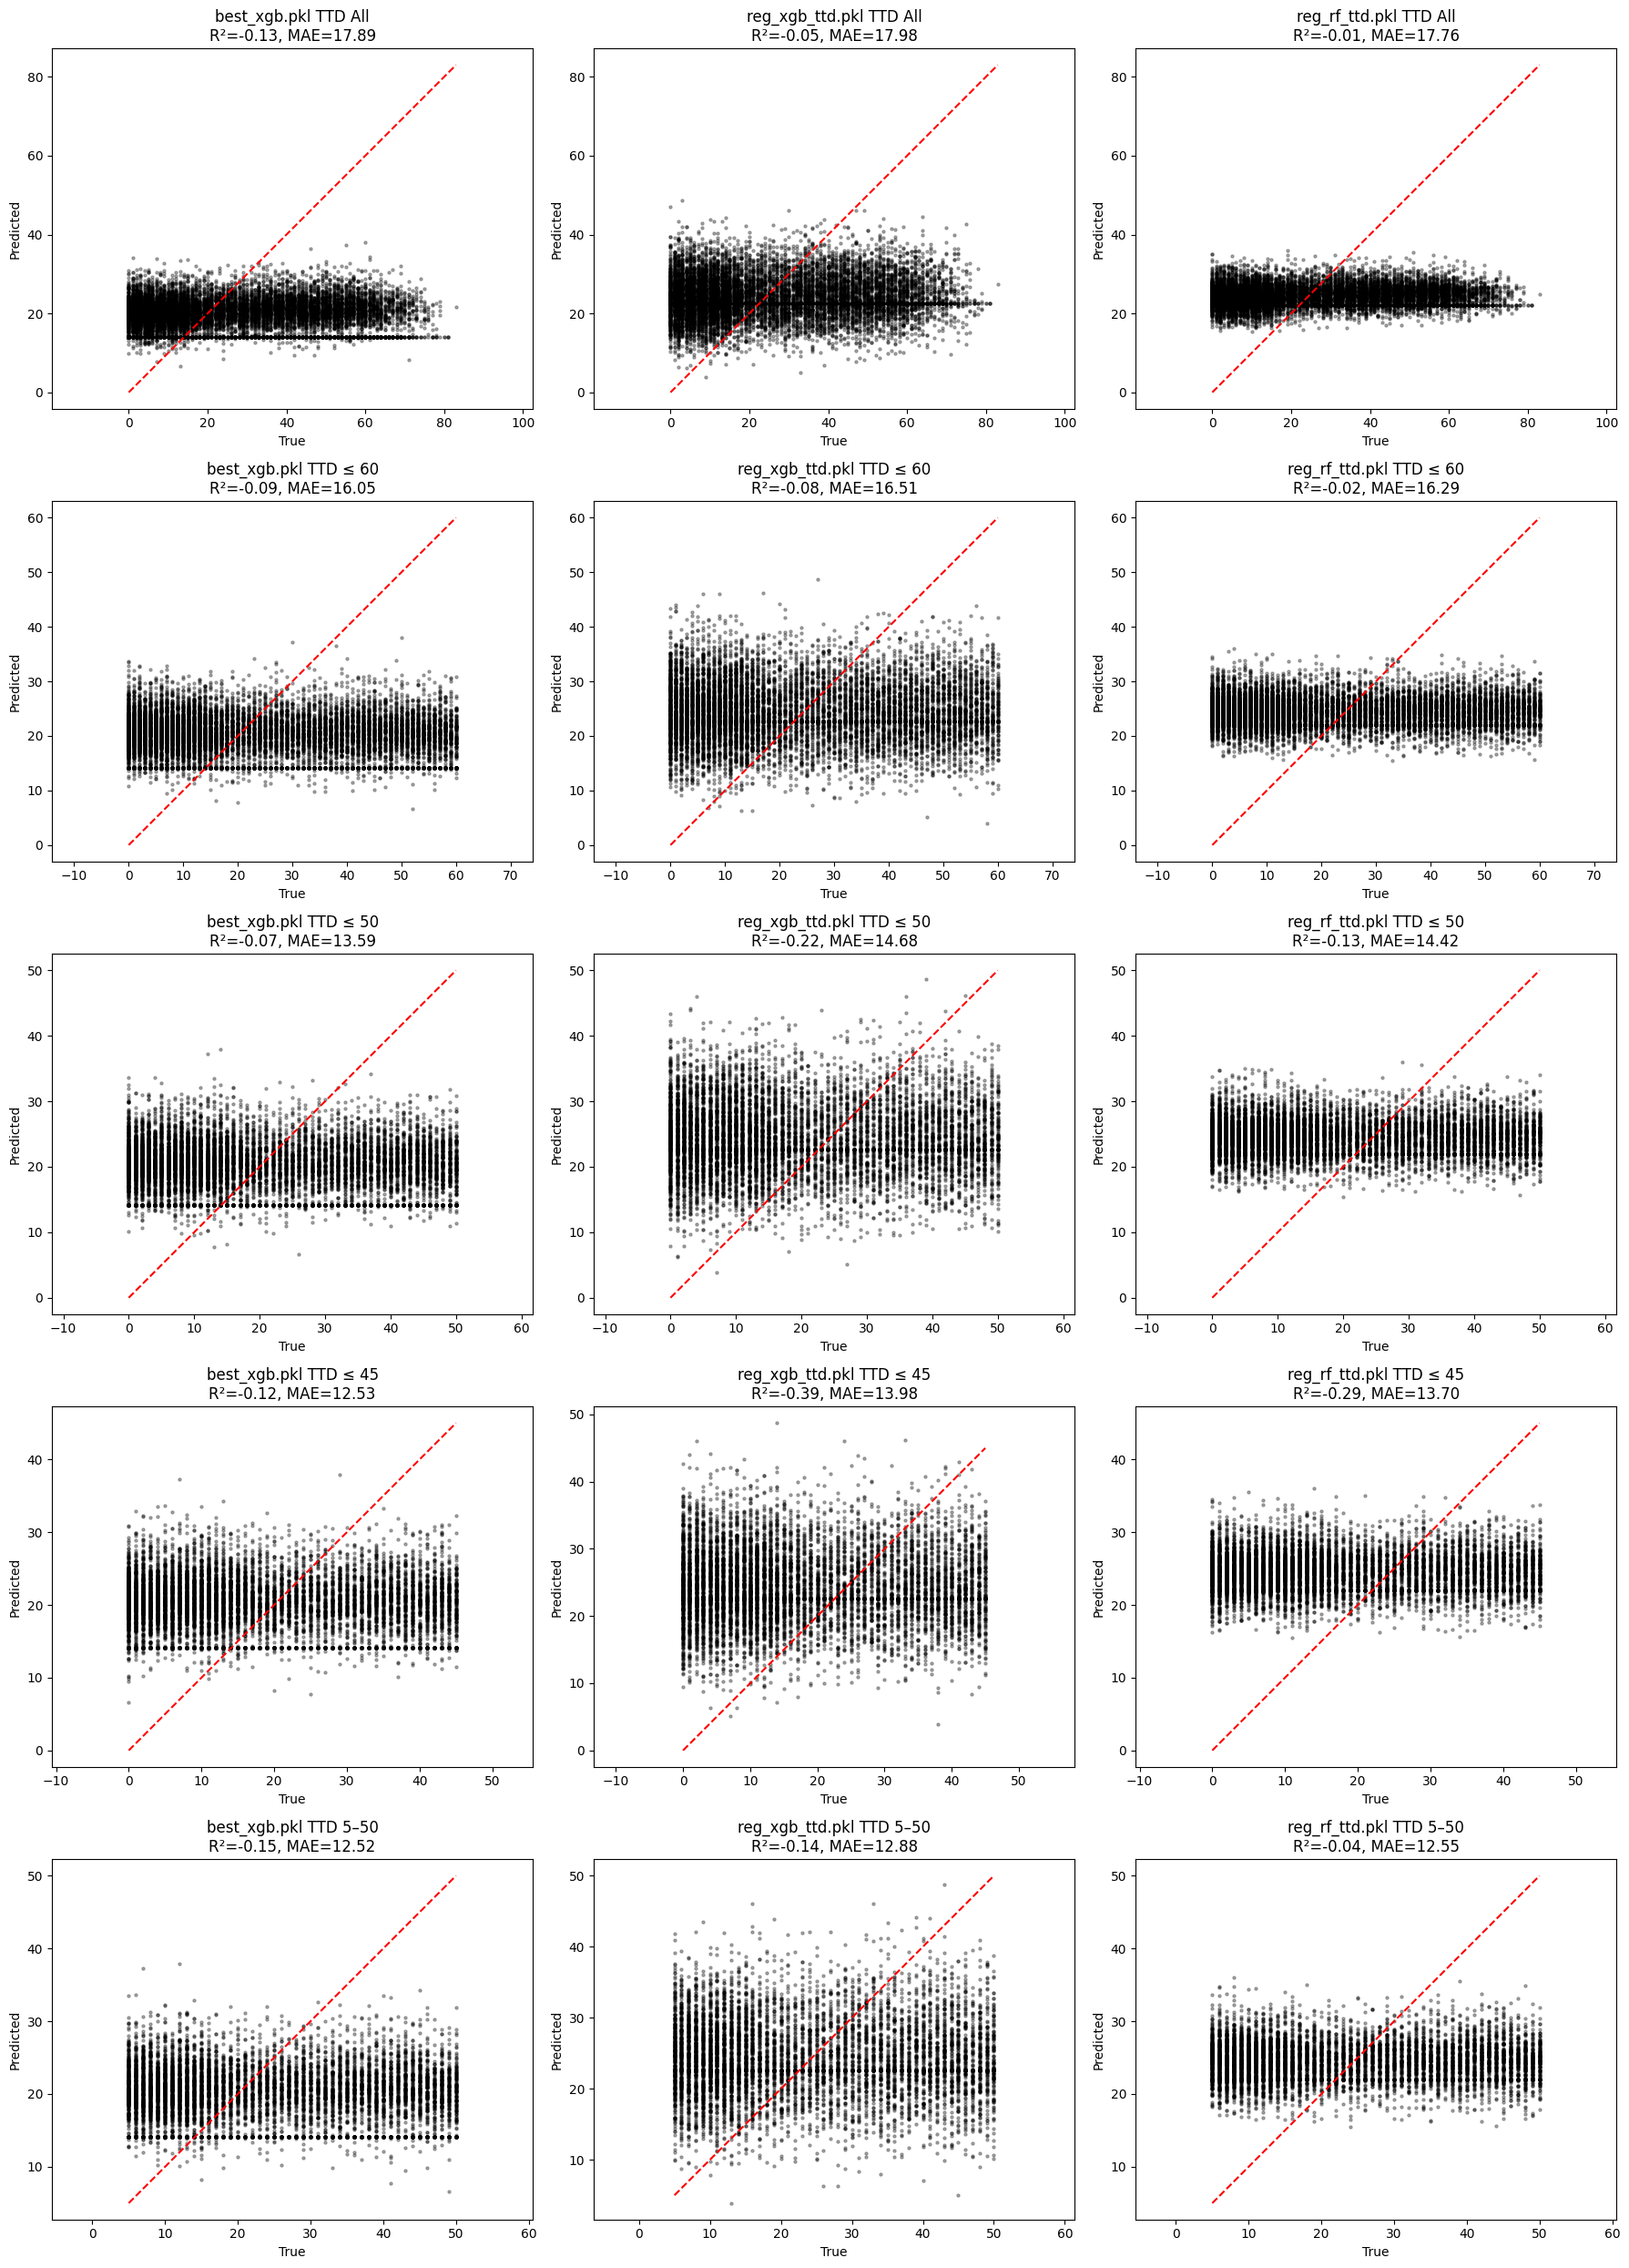

In [29]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
}

ttd_filters = {
    "All": lambda df: df,
    "≤ 60": lambda df: df[df["time_to_death"] <= 60],
    "≤ 50": lambda df: df[df["time_to_death"] <= 50],
    "≤ 45": lambda df: df[df["time_to_death"] <= 45],
    "5–50": lambda df: df[(df["time_to_death"] >= 5) & (df["time_to_death"] <= 50)]
}

# === Load CSV
df_full_orig = pd.read_csv(csv_path)
df_full_orig = df_full_orig.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)
print(f"✅ Loaded full dataset with {len(df_full_orig)} entries")

# === Load age scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Extract and cache image features
if os.path.exists(cache_path):
    X_all = np.load(cache_path)
    df_full = df_full_orig.copy()
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    valid_indices = []
    for i, row in tqdm(df_full_orig.iterrows(), total=len(df_full_orig)):
        try:
            path = os.path.join(image_dir, row["full_path"])
            image = Image.open(path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()
            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan
            f = np.concatenate([img_feat, [scaled_age, gender]])
            features.append(f)
            valid_indices.append(i)
        except:
            continue

    X_all = np.array(features)
    df_full = df_full_orig.iloc[valid_indices].reset_index(drop=True)
    np.save(cache_path, X_all)
    print("✅ Saved image features to cache.")

# === Plotting setup
n_rows = len(ttd_filters)
n_cols = len(model_paths)
plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for row_idx, (ttd_label, ttd_filter) in enumerate(ttd_filters.items()):
    df_filtered = ttd_filter(df_full).reset_index(drop=True)
    y_true_all = df_filtered["time_to_death"].values
    indices = df_filtered.index.values
    X = X_all[indices]

    for col_idx, (model_label, model_path) in enumerate(model_paths.items()):
        model = joblib.load(model_path)
        print(f"📊 Evaluating {model_label} on TTD: {ttd_label} with {len(df_filtered)} samples")

        features_adj = []
        for f in X:
            model_input_dim = getattr(model, "n_features_in_", len(f))
            if len(f) < model_input_dim:
                f = np.concatenate([f, np.zeros(model_input_dim - len(f))])
            elif len(f) > model_input_dim:
                f = f[:model_input_dim]
            features_adj.append(f)

        X_adj = np.array(features_adj)
        y_pred = model.predict(X_adj)
        r2 = r2_score(y_true_all, y_pred)
        mae = mean_absolute_error(y_true_all, y_pred)

        # Subplot
        plot_idx = row_idx * n_cols + col_idx + 1
        plt.subplot(n_rows, n_cols, plot_idx)
        plt.scatter(y_true_all, y_pred, s=5, color='black', alpha=0.3)
        plt.plot([y_true_all.min(), y_true_all.max()], [y_true_all.min(), y_true_all.max()], 'r--')
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.title(f"{model_label} TTD {ttd_label}\nR²={r2:.2f}, MAE={mae:.2f}")
        plt.axis("equal")

plt.tight_layout()
plt.show()


✅ Filtered to 10663 samples with TTD ≤ 50 years
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached_ttd50.npy

🚀 Running model: best_xgb.pkl


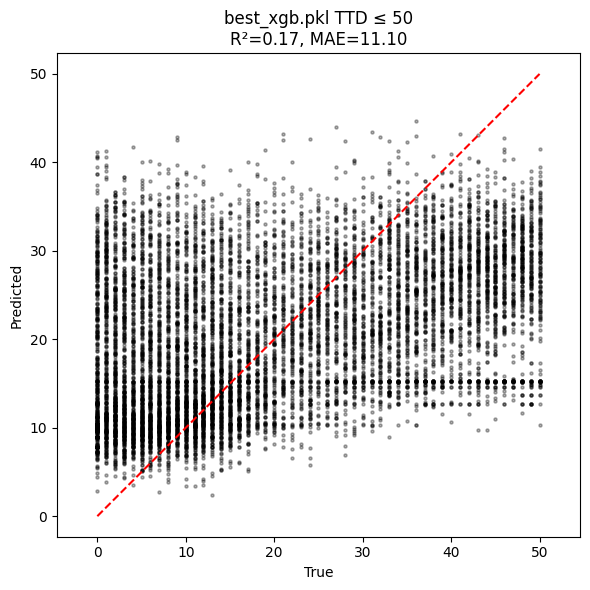

✅ Finished best_xgb.pkl: 10663 predictions

🚀 Running model: reg_xgb_ttd.pkl


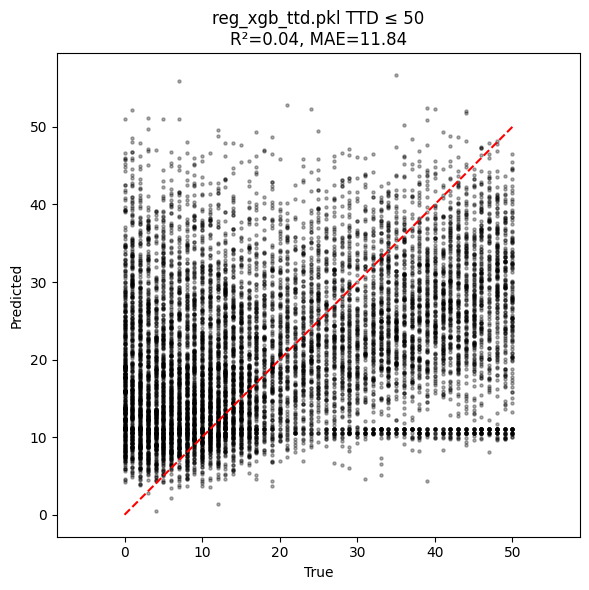

✅ Finished reg_xgb_ttd.pkl: 10663 predictions

🚀 Running model: reg_rf_ttd.pkl


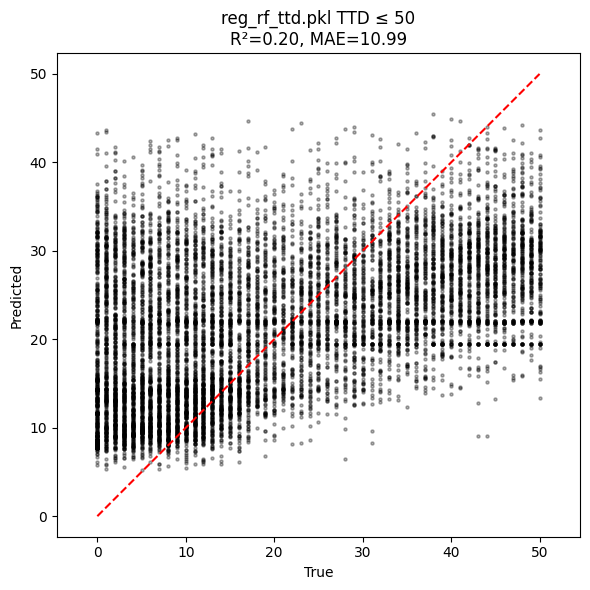

✅ Finished reg_rf_ttd.pkl: 10663 predictions


In [28]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached_ttd50.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
}

# === Load and filter dataframe
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 50].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 50 years")

# === Load scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Load or compute image features
if os.path.exists(cache_path):
    X_base = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            path = os.path.join(image_dir, row["full_path"])
            image = Image.open(path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()
            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan
            f = np.concatenate([img_feat, [scaled_age, gender]])
            features.append(f)
        except:
            features.append(None)

    X_base = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X_base)
    print("✅ Saved image features to cache.")

# === Run for each model
for model_label, model_path in model_paths.items():
    print(f"\n🚀 Running model: {model_label}")
    model = joblib.load(model_path)

    # Pad or trim input features
    model_input_dim = getattr(model, "n_features_in_", X_base.shape[1])
    X = []
    for f in X_base:
        if len(f) < model_input_dim:
            f = np.concatenate([f, np.zeros(model_input_dim - len(f))])
        elif len(f) > model_input_dim:
            f = f[:model_input_dim]
        X.append(f)
    X = np.array(X)

    # === Predict and evaluate
    y_true = df["time_to_death"].values
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # === Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{model_label} TTD ≤ 50\nR²={r2:.2f}, MAE={mae:.2f}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    print(f"✅ Finished {model_label}: {len(y_true)} predictions")


✅ Filtered to 12025 samples with TTD ≤ 60 years
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached_ttd60.npy

🚀 Running model: best_xgb.pkl


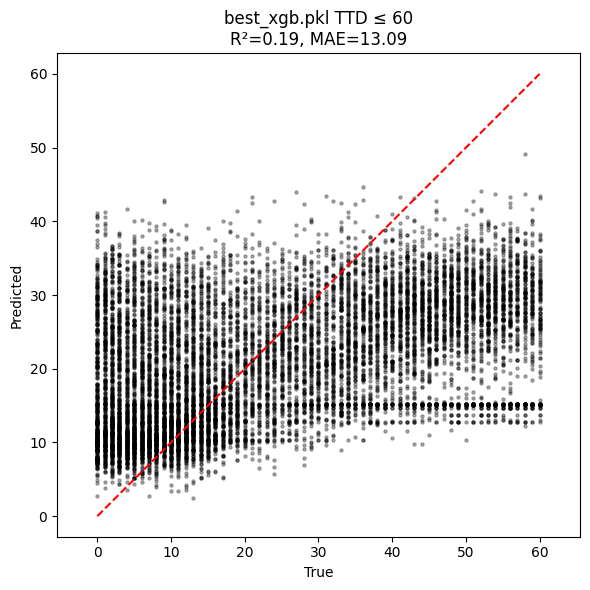

✅ Finished best_xgb.pkl: 12025 predictions

🚀 Running model: reg_xgb_ttd.pkl


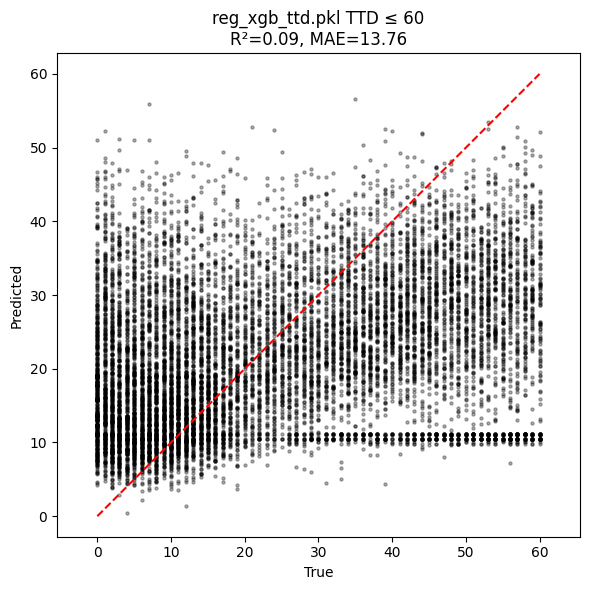

✅ Finished reg_xgb_ttd.pkl: 12025 predictions

🚀 Running model: reg_rf_ttd.pkl


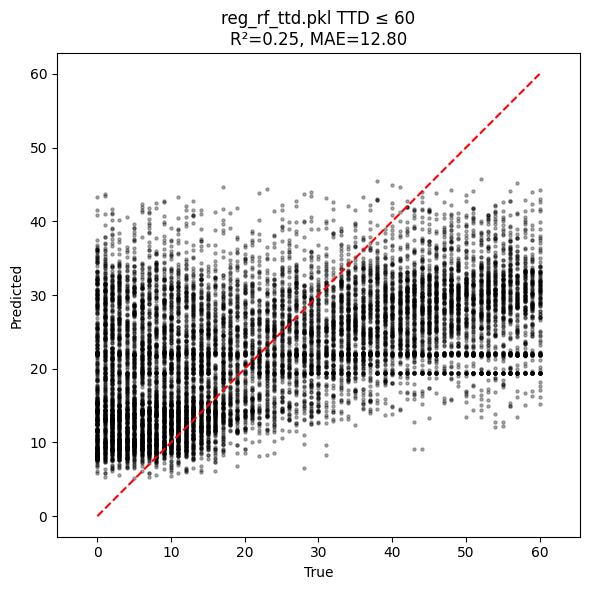

✅ Finished reg_rf_ttd.pkl: 12025 predictions


In [30]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached_ttd60.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
}

# === Load and filter dataframe
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 60].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 60 years")

# === Load scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Load or compute image features
if os.path.exists(cache_path):
    X_base = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            path = os.path.join(image_dir, row["full_path"])
            image = Image.open(path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()
            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan
            f = np.concatenate([img_feat, [scaled_age, gender]])
            features.append(f)
        except:
            features.append(None)

    X_base = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X_base)
    print("✅ Saved image features to cache.")

# === Run for each model
for model_label, model_path in model_paths.items():
    print(f"\n🚀 Running model: {model_label}")
    model = joblib.load(model_path)

    # Pad or trim input features
    model_input_dim = getattr(model, "n_features_in_", X_base.shape[1])
    X = []
    for f in X_base:
        if len(f) < model_input_dim:
            f = np.concatenate([f, np.zeros(model_input_dim - len(f))])
        elif len(f) > model_input_dim:
            f = f[:model_input_dim]
        X.append(f)
    X = np.array(X)

    # === Predict and evaluate
    y_true = df["time_to_death"].values
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # === Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{model_label} TTD ≤ 60\nR²={r2:.2f}, MAE={mae:.2f}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    print(f"✅ Finished {model_label}: {len(y_true)} predictions")


✅ Filtered to 9931 samples with TTD ≤ 45 years
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached_ttd45.npy

🚀 Running model: best_xgb.pkl


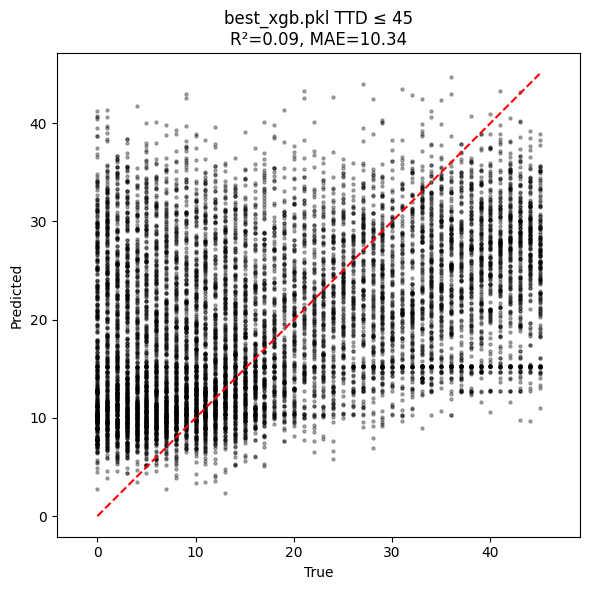

✅ Finished best_xgb.pkl: 9931 predictions

🚀 Running model: reg_xgb_ttd.pkl


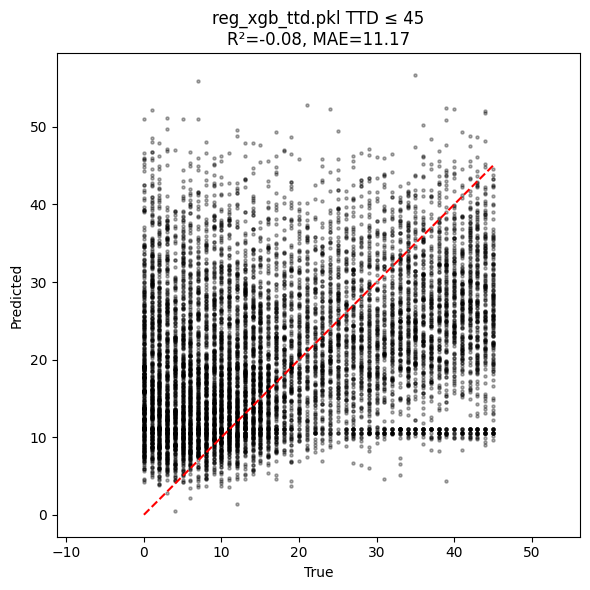

✅ Finished reg_xgb_ttd.pkl: 9931 predictions

🚀 Running model: reg_rf_ttd.pkl


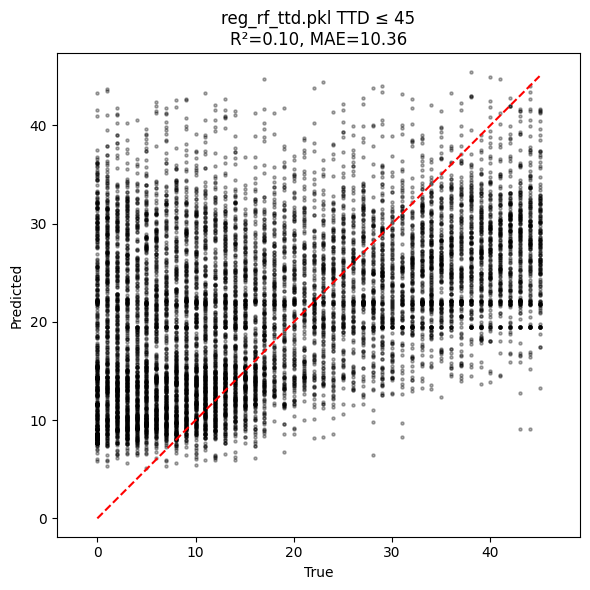

✅ Finished reg_rf_ttd.pkl: 9931 predictions


In [31]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached_ttd45.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
}

# === Load and filter dataframe
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[df["time_to_death"] <= 45].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with TTD ≤ 45 years")

# === Load scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Load or compute image features
if os.path.exists(cache_path):
    X_base = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            path = os.path.join(image_dir, row["full_path"])
            image = Image.open(path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()
            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan
            f = np.concatenate([img_feat, [scaled_age, gender]])
            features.append(f)
        except:
            features.append(None)

    X_base = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X_base)
    print("✅ Saved image features to cache.")

# === Run for each model
for model_label, model_path in model_paths.items():
    print(f"\n🚀 Running model: {model_label}")
    model = joblib.load(model_path)

    # Pad or trim input features
    model_input_dim = getattr(model, "n_features_in_", X_base.shape[1])
    X = []
    for f in X_base:
        if len(f) < model_input_dim:
            f = np.concatenate([f, np.zeros(model_input_dim - len(f))])
        elif len(f) > model_input_dim:
            f = f[:model_input_dim]
        X.append(f)
    X = np.array(X)

    # === Predict and evaluate
    y_true = df["time_to_death"].values
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # === Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{model_label} TTD ≤ 45\nR²={r2:.2f}, MAE={mae:.2f}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    print(f"✅ Finished {model_label}: {len(y_true)} predictions")


✅ Filtered to 7978 samples with 5 years ≤ TTD ≤ 45 years
✅ Loaded age scaler.
📂 Loaded cached image features from /content/image_features_cached_ttd_5to45.npy

🚀 Running model: best_xgb.pkl


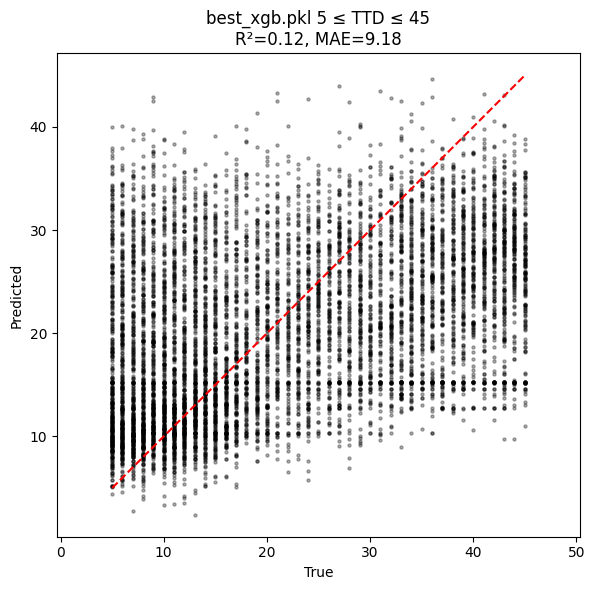

✅ Finished best_xgb.pkl: 7978 predictions

🚀 Running model: reg_xgb_ttd.pkl


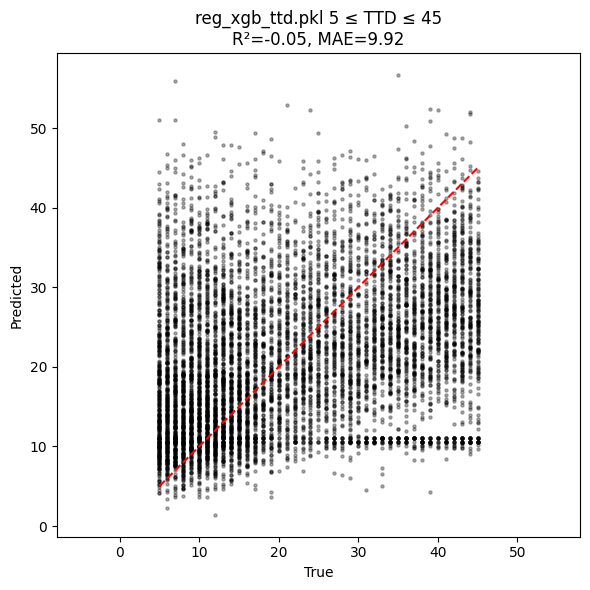

✅ Finished reg_xgb_ttd.pkl: 7978 predictions

🚀 Running model: reg_rf_ttd.pkl


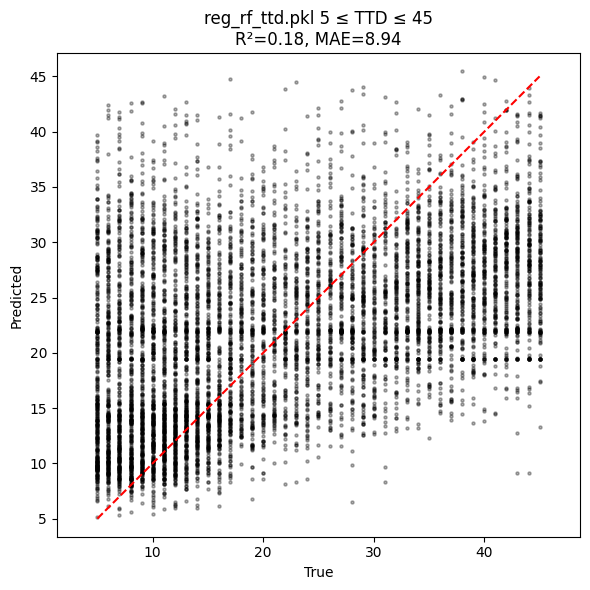

✅ Finished reg_rf_ttd.pkl: 7978 predictions


In [32]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached_ttd_5to45.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl"
}

# === Load and filter dataframe
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"])
df = df[(df["time_to_death"] >= 5) & (df["time_to_death"] <= 45)].reset_index(drop=True)
print(f"✅ Filtered to {len(df)} samples with 5 years ≤ TTD ≤ 45 years")

# === Load scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Load or compute image features
if os.path.exists(cache_path):
    X_base = np.load(cache_path)
    print(f"📂 Loaded cached image features from {cache_path}")
else:
    print("🔄 Extracting image features...")
    features = []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        try:
            path = os.path.join(image_dir, row["full_path"])
            image = Image.open(path).convert("L").resize((64, 64))
            img_feat = np.array(image).flatten()
            age = row["age_at_photo"]
            scaled_age = age_scaler.transform(np.array(age).reshape(1, -1))[0, 0] if age_scaler else age
            gender = np.nan
            f = np.concatenate([img_feat, [scaled_age, gender]])
            features.append(f)
        except:
            features.append(None)

    X_base = np.array([f for f in features if f is not None])
    df = df.iloc[[i for i, f in enumerate(features) if f is not None]].reset_index(drop=True)
    np.save(cache_path, X_base)
    print("✅ Saved image features to cache.")

# === Run for each model
for model_label, model_path in model_paths.items():
    print(f"\n🚀 Running model: {model_label}")
    model = joblib.load(model_path)

    # Pad or trim input features
    model_input_dim = getattr(model, "n_features_in_", X_base.shape[1])
    X = []
    for f in X_base:
        if len(f) < model_input_dim:
            f = np.concatenate([f, np.zeros(model_input_dim - len(f))])
        elif len(f) > model_input_dim:
            f = f[:model_input_dim]
        X.append(f)
    X = np.array(X)

    # === Predict and evaluate
    y_true = df["time_to_death"].values
    y_pred = model.predict(X)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # === Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{model_label} 5 ≤ TTD ≤ 45\nR²={r2:.2f}, MAE={mae:.2f}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    print(f"✅ Finished {model_label}: {len(y_true)} predictions")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Loading cached image features...
✅ Loaded age scaler.

🚀 Running model: best_xgb.pkl
📐 Padded to match model's input: 4436 features.
📊 Running predictions...


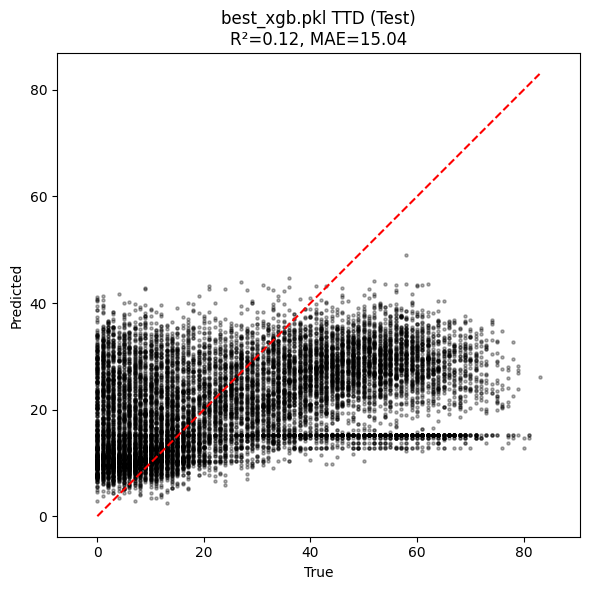

✅ Completed best_xgb.pkl: 12911 predictions.

🚀 Running model: reg_rf_ttd.pkl
📊 Running predictions...


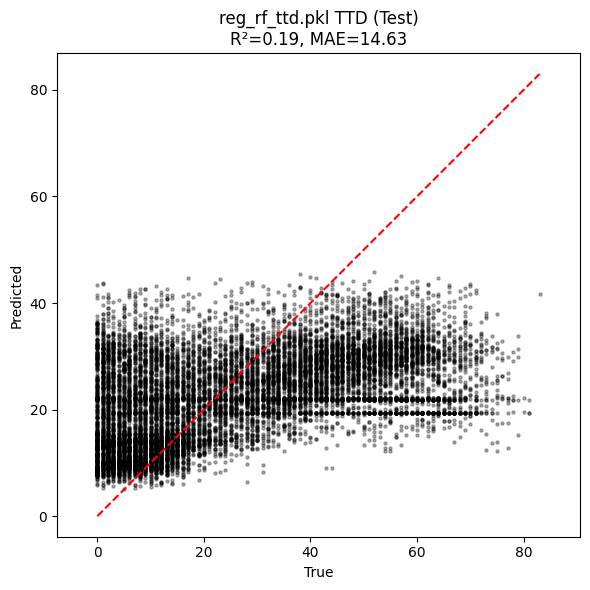

✅ Completed reg_rf_ttd.pkl: 12911 predictions.

🚀 Running model: reg_xgb_ttd.pkl
📊 Running predictions...


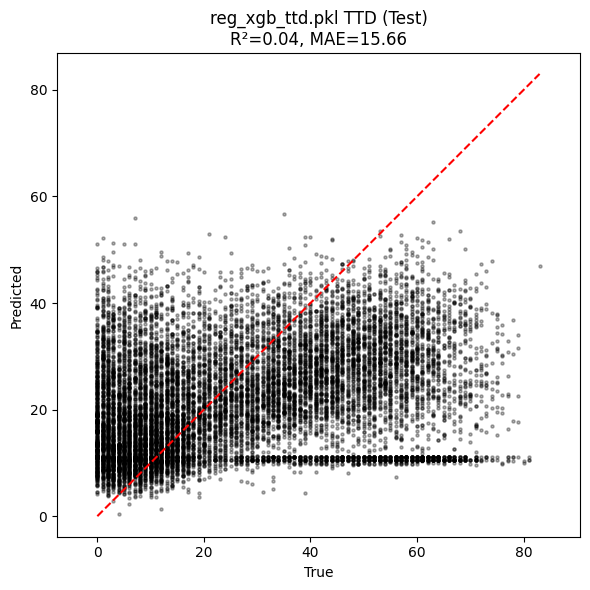

✅ Completed reg_xgb_ttd.pkl: 12911 predictions.


In [34]:
# 📦 Install required packages
!pip install -q joblib pandas matplotlib scikit-learn pillow tqdm

# 📚 Imports
import pandas as pd
import numpy as np
import joblib
import os
from PIL import Image
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# === Mount Google Drive (make sure it's mounted)
from google.colab import drive
drive.mount('/content/drive')

# === Paths ===
csv_path = "/content/drive/MyDrive/Gladyshev/data/wiki_metadata/wiki_deaths_filtered_age_photo_valid.csv"
image_dir = "/content/drive/MyDrive/Gladyshev/data/wiki_crop_unzip/wiki_crop"
scaler_path = "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/age_scaler_icfaceage.pkl"
cache_path = "/content/image_features_cached.npy"

model_paths = {
    "best_xgb.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/best_xgb.pkl",
    "reg_rf_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_rf_ttd.pkl",
    "reg_xgb_ttd.pkl": "/content/drive/MyDrive/Gladyshev/data/bestrun_time_to_death/reg_xgb_ttd.pkl"
}

# === Load data
df = pd.read_csv(csv_path)
df = df.dropna(subset=["age_at_photo", "full_path", "time_to_death"]).reset_index(drop=True)

# === Load or extract image features
if os.path.exists(cache_path):
    print("📦 Loading cached image features...")
    image_features = np.load(cache_path)
else:
    print("🔄 Extracting image features...")

    def extract_image(path):
        try:
            img = Image.open(os.path.join(image_dir, path)).convert("L").resize((64, 64))
            return np.array(img).flatten()
        except:
            return None

    image_features = Parallel(n_jobs=32)(
        delayed(extract_image)(fp) for fp in tqdm(df["full_path"])
    )
    valid_idx = [i for i, feat in enumerate(image_features) if feat is not None]
    df = df.iloc[valid_idx].reset_index(drop=True)
    image_features = np.array([image_features[i] for i in valid_idx])
    np.save(cache_path, image_features)
    print("✅ Cached image features saved.")

# === Load scaler
try:
    age_scaler = joblib.load(scaler_path)
    print("✅ Loaded age scaler.")
except:
    age_scaler = None
    print("⚠️ No scaler found. Using raw age.")

# === Metadata
ages = df["age_at_photo"].values.reshape(-1, 1)
scaled_ages = age_scaler.transform(ages).flatten() if age_scaler else ages.flatten()
genders = np.full_like(scaled_ages, fill_value=np.nan)

# === Feature matrix
base_features = np.concatenate([image_features, scaled_ages[:, None], genders[:, None]], axis=1)

# === Run each model
for model_label, model_path in model_paths.items():
    print(f"\n🚀 Running model: {model_label}")
    model = joblib.load(model_path)

    expected_features = getattr(model, "n_features_in_", base_features.shape[1])
    if base_features.shape[1] < expected_features:
        X = np.hstack([base_features, np.zeros((base_features.shape[0], expected_features - base_features.shape[1]))])
        print(f"📐 Padded to match model's input: {expected_features} features.")
    elif base_features.shape[1] > expected_features:
        X = base_features[:, :expected_features]
        print(f"✂️ Truncated features to: {expected_features}.")
    else:
        X = base_features

    # === Predict
    print("📊 Running predictions...")
    y_true = df["time_to_death"].values
    y_pred = model.predict(X)

    # === Evaluate
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # === Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=5, color='black', alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{model_label} TTD (Test)\nR²={r2:.2f}, MAE={mae:.2f}")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

    print(f"✅ Completed {model_label}: {len(y_true)} predictions.")

https://chatgpt.com/share/686a04ad-54b8-8008-ac86-7e9018b98021